## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow 
import keras

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn import tree

output_notebook()


%matplotlib inline

Using TensorFlow backend.
/Users/yubozhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading BokehJS ...

In [2]:
# Load the data
data = pd.read_csv('../data/train.csv')
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)


def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [3]:
#Remove unnecessary variables
#del data['AnimalID']
#del data['Name']
#del data['DateTime']
#del data['Breed']
#del data['OutcomeSubtype']
#del data['SexuponOutcome']
#del data['AgeuponOutcome']
#del data['Color']
#del data['OrderedBreed']
#del data['OrderedColor']

continuous = ['ConvertedAge']
discrete = [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named'
]
target = 'OutcomeType'

print data.ConvertedAge.unique()

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
data[continuous].describe().T

[  5.20000000e+01   1.04000000e+02   3.00000000e+00   4.50000000e+00
   2.25000000e+01   2.08000000e+02   1.35000000e+01   2.00000000e+00
   9.00000000e+00   4.50000000e+01   2.70000000e+01   2.60000000e+02
   3.64000000e+02   1.56000000e+02   1.80000000e+01   6.24000000e+02
   4.68000000e+02   3.12000000e+02   1.00000000e+00   5.72000000e+02
   4.00000000e+00   3.15000000e+01   4.16000000e+02   4.95000000e+01
   0.00000000e+00   4.05000000e+01   3.60000000e+01   7.80000000e+02
   5.20000000e+02   7.28000000e+02   5.00000000e+00   8.32000000e+02
   6.76000000e+02              nan   8.84000000e+02   9.36000000e+02
   9.88000000e+02   1.04000000e+03]


,count,mean,std,min,25%,50%,75%,max
ConvertedAge,26729.0,113.370253,154.064766,0.0,9.0,52.0,156.0,1040.0


In [4]:
#Turn categorical variables into binaries
data2 = pd.concat([data[target], data[continuous], pd.get_dummies(data[discrete])], axis=1)

data2.head()
data2.shape

(26729, 15)

In [73]:
discrete = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed']

predictors = continuous + discrete

# Train/test split
X = data2[predictors]
y = data2[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

#Normalize 
ss = StandardScaler()
ss.fit(X_train[continuous])   # Compute mean and std of training data
X_train[continuous] = ss.transform(X_train[continuous])  # Use that mean and std to normalize columns of training data
X_dev[continuous] = ss.transform(X_dev[continuous]) 

/Users/yubozhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yubozhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Visualizing Features

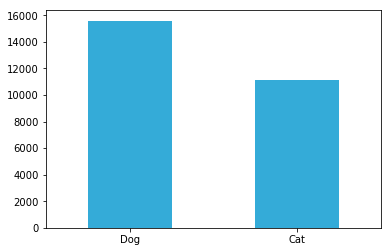

In [6]:
#A quick look at the variables

#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [7]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

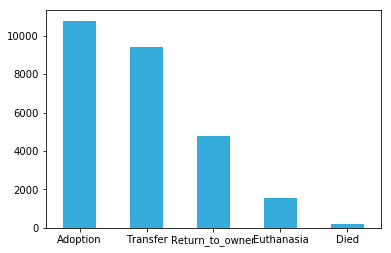

In [8]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

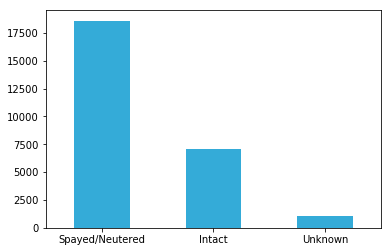

In [9]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [10]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

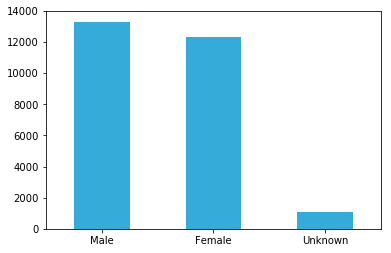

In [11]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [12]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

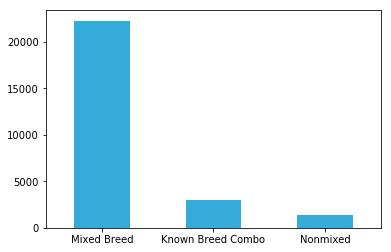

In [13]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [14]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121e32950>]], dtype=object)

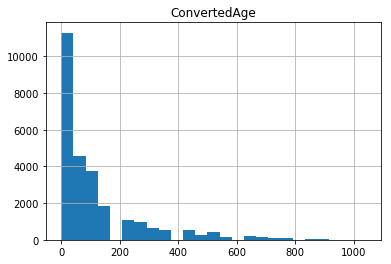

In [15]:
data.hist(column="ConvertedAge", bins=25)

In [16]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

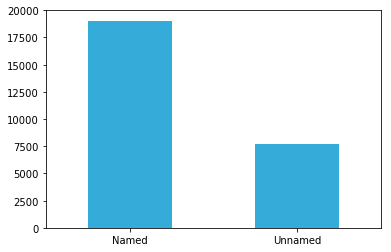

In [17]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [18]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [19]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

('Unique Colors', 275)
['Brown White' 'Cream-Tabby' 'Blue White' 'Blue-Cream' 'Tan' 'Black Tan'
 'Blue-Tabby' 'Brown-Tabby' 'Red White' 'White' 'Black' 'Silver' 'Brown'
 'Black Red' 'Cream White' 'Orange-Tabby White' 'Black White'
 'Brown-Brindle White' 'Black Brown' 'Orange-Tabby' 'Chocolate White'
 'Tan White' 'Cream-Tabby White' 'Blue' 'Calico' 'Torbie' 'Yellow'
 'Tricolor' 'Tortie' 'Blue-Tabby White' 'Gray White' 'Buff'
 'Brown-Tabby White' 'Red' 'Blue Tan' 'Seal-Point' 'Brown-Brindle' 'Gray'
 'White Yellow-Brindle' 'Fawn White' 'Flame-Point' 'Black-Tabby White'
 'Calico Tortie' 'Black Brown-Brindle' 'Silver Tan' 'Black Red-Tick'
 'Blue-Merle' 'Chocolate Tan' 'Sable' 'Brown-Merle White'
 'Brown-Tiger White' 'Liver White' 'Black Gray' 'Cream' 'Chocolate'
 'Blue-Point' 'Apricot White' 'Black Red-Merle' 'Blue-Merle White' 'Fawn'
 'Lynx-Point White' 'Black Fawn' 'Red-Tick White' 'Buff Tan'
 'Brown-Brindle Red-Tick' 'Lilac-Point' 'Buff White' 'Tortie-Point'
 'Lynx-Point' 'Tortie White' 

In [20]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

('Unique Breeds', 1143)
['Shetland-Sheepdog-Mix' 'Domestic-Shorthair-Mix' 'Pit-Bull-Mix' ...,
 'English-Bulldog French-Bulldog' 'Boxer Vizsla'
 'Australian-Kelpie German-Shepherd']


In [21]:
def main():
    print "Number of observations: ", len(data.index)
    print "Number of columns: ", len(data.columns)
    print "Headers: ", data.columns.values

if __name__ == "__main__":
    main()



Number of observations:  26729
Number of columns:  17
Headers:  ['AnimalID' 'Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color' 'Female' 'ConvertedAge'
 'Intact' 'MixedBreed' 'Named' 'OrderedColor' 'OrderedBreed']


### LOGISTIC REGRESSION

In [75]:
print X_train.shape
print X_dev.shape
print y_train.shape
print y_dev.shape

(20046, 14)
(6683, 14)
(20046, 1)
(6683, 1)


#### Generate logistic regression

In [76]:
# Select C from 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0 and the highes accuracy is when C=0.5

for m in [ 0.5]: # 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_train, y_train)
    weight1 = lrq.coef_
    sum1 = sum(sum(weight1))
    print 'The mean accuracy when the regularization strength C is', m,  'is ', lrq.score(X_dev, y_dev), 'and the sum of the squared weight is', sum1


The mean accuracy when the regularization strength C is 0.5 is  0.633996708065 and the sum of the squared weight is -21.1666084718


#### Feature engineering

For this dataset, we have 14 different features, including gender, breed, age and so on.  In order to select the best
feature to add to the model, we can go either bottom up starting from only 1 feature and add more feature based on
the accuracy, or go down by deleting features. 



In [80]:
# Start the bottom up feature selection with Greedy algorithm 
# Compute the accuracy of logistic regression with N features

train = X_train
dev = X_dev

bestVec = [] 

for j in range(14):
    maxacc = 0
    maxi = 0
    for i in range(14):
        if i not in bestVec:
            X_train_eng = pd.DataFrame(train.ix[:, bestVec + [i]])
            X_dev_eng = pd.DataFrame(dev.ix[:, bestVec + [i]])
            m=.5
            lrq = LogisticRegression(C = m, penalty = 'l2')
            lrq.fit(X_train_eng, y_train)
            if lrq.score(X_dev_eng, y_dev) > maxacc:
                maxacc = lrq.score(X_dev_eng, y_dev)
                maxi = i
    bestVec = bestVec + [maxi]
    print 'When the number of features used is ', j+1 ,', the best feature to add to the model is ', predictors[maxi] ,', and the accurancy is', maxacc

When the number of features used is  1 , the best feature to add to the model is  Intact_Spayed/Neutered , and the accurancy is 0.608259763579
When the number of features used is  2 , the best feature to add to the model is  ConvertedAge , and the accurancy is 0.620828969026
When the number of features used is  3 , the best feature to add to the model is  AnimalType_Cat , and the accurancy is 0.628161005536
When the number of features used is  4 , the best feature to add to the model is  MixedBreed_Known Breed Combo , and the accurancy is 0.631303306898
When the number of features used is  5 , the best feature to add to the model is  Named_Unnamed , and the accurancy is 0.634595241658
When the number of features used is  6 , the best feature to add to the model is  MixedBreed_Nonmixed , and the accurancy is 0.634744875056
When the number of features used is  7 , the best feature to add to the model is  AnimalType_Dog , and the accurancy is 0.634744875056
When the number of features use

We can see from the above that when the number of feature is 6, the model has the highest accuracy of 0.634744875056, 
the model did not increase the accurcy by adding additional features. 

The six features include: Intact_Spayed/Neutered, ConvertedAge, AnimalType_Cat, MixedBreed_Known Breed Combo, Named_Unnamed, and MixedBreed_Nonmixed.  Next we will exam each features to evaluate each impact on the overal outcome.

#### Check Spayed/Neutered 

Since Spayed/Neutered is the first feature from the logistic regression list, it would be interesting to check if the data with only Spayed/Neutered and the data with only intact have better accuracy than original dataset. 

In [87]:
# Dataset with only Spayed/Neutered and intact
X_spayed = train[train['Intact_Spayed/Neutered'] == 1]
X_intact = train[train['Intact_Intact'] == 1]

y_spayed = y_train[train['Intact_Spayed/Neutered'] == 1]
y_intact = y_train[train['Intact_Intact'] == 1]

Xdev_spayed = dev[dev['Intact_Spayed/Neutered'] == 1]
Xdev_intact = dev[dev['Intact_Intact'] == 1]

ydev_spayed = y_dev[dev['Intact_Spayed/Neutered'] == 1]
ydev_intact = y_dev[dev['Intact_Intact'] == 1]


(13969, 14)
(5267, 14)


In [94]:
# logistic regression with only Spayed/Neutered 
for m in [0.1]:     # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_spayed, y_spayed)
    print 'The mean accuracy when the regularization strength C for Spayed/Neutered dataset', m,  'is ', lrq.score(Xdev_spayed, ydev_spayed)

The mean accuracy when the regularization strength C for Spayed/Neutered dataset 0.1 is  0.593392355863


In [95]:
# logistic regression with only intact
for m in [0.1]:     # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_intact, y_intact)
    print 'The mean accuracy when the regularization strength C for intact dataset', m,  'is ', lrq.score(Xdev_intact, ydev_intact)

The mean accuracy when the regularization strength C for intact dataset 0.1 is  0.708875070661


Looks like the dataset with only intact animal have a better accuracy than the original dataset. 

#### Check ConvertedAge

Let's exam the age impact on the accuracy of the data. Consider kitten/puppy is from 0-1 year old, adult cat/dog is 1-7 years old, and senior/mature cat/dog is larger than 7 years old. The data can be divided into three dataset: youth, adult and senior. 

In [106]:
# Dataset with youth, adult and senior pets

X_youth = train[train['ConvertedAge'] <= 52]
X_adult = 52 < train[train['ConvertedAge'] < 364]
X_senior = train[train['ConvertedAge'] >= 364]

y_youth = y_train[train['ConvertedAge'] <= 52]
y_adult = 52 < y_train[train['ConvertedAge'] < 364]
y_senior = y_train[train['ConvertedAge'] >= 364]

Xdev_youth = dev[dev['ConvertedAge'] <= 52]
Xdev_adult = 52 < dev[dev['ConvertedAge'] < 364]
Xdev_senior = dev[dev['ConvertedAge'] >= 364]

ydev_youth = y_dev[dev['ConvertedAge'] <= 52]
ydev_adult = 52 < y_dev[dev['ConvertedAge'] < 364]
ydev_senior = y_dev[dev['ConvertedAge'] >= 364]

In [109]:
# Logistic regression with youth pets

for m in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]:
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_youth, y_youth)
    print 'The mean accuracy when the regularization strength C for kitten/puppy dataset', m,  'is ', lrq.score(Xdev_youth, ydev_youth)

The mean accuracy when the regularization strength C for kitten/puppy dataset 1e-05 is  0.56471644471
The mean accuracy when the regularization strength C for kitten/puppy dataset 0.0001 is  0.612449498728
The mean accuracy when the regularization strength C for kitten/puppy dataset 0.001 is  0.628759539129
The mean accuracy when the regularization strength C for kitten/puppy dataset 0.01 is  0.63279964088
The mean accuracy when the regularization strength C for kitten/puppy dataset 0.1 is  0.633697441269
The mean accuracy when the regularization strength C for kitten/puppy dataset 1.0 is  0.633996708065
The mean accuracy when the regularization strength C for kitten/puppy dataset 2.0 is  0.633996708065
The mean accuracy when the regularization strength C for kitten/puppy dataset 4.0 is  0.633996708065
The mean accuracy when the regularization strength C for kitten/puppy dataset 6.0 is  0.633996708065
The mean accuracy when the regularization strength C for kitten/puppy dataset 8.0 is 

#### Decision trees

In [56]:
dt = DecisionTreeRegressor()
dt.fit(X_train[predictors], y_train_hot)

pred = dt.predict(X_train[predictors])
print pred
mse = np.mean( (pred - y_train_hot) ** 2)
print 'Mean squared error = {}'.format(mse)
print 'The accuracy is',dt.score(X_train[predictors], y_train_hot)

[[ 0.53275862  0.00344828  0.03448276  0.28275862  0.14655172]
 [ 0.14285714  0.          0.35714286  0.14285714  0.35714286]
 [ 0.68627451  0.          0.          0.1372549   0.17647059]
 ..., 
 [ 0.92682927  0.          0.          0.01626016  0.05691057]
 [ 0.86448598  0.          0.          0.00934579  0.12616822]
 [ 0.          0.          0.          0.          1.        ]]
Mean squared error = 0.0877633407083
The accuracy is 0.352168793847


Looks like we only get 0.35 on accuracy with decision trees on the training data

#### Random forest

In [58]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=50, oob_score=True)
scores = cross_val_score(rf, X_train[predictors], y_train_hot, cv=10)
print scores.mean()

0.29092608207


### Neural Network 

We will use Keras for neural network training. 

In [41]:
# hot encoding to transform training and development data
lb_style = LabelBinarizer()
y_train_hot = lb_style.fit_transform(y_train)
y_train_hot
y_dev_hot = lb_style.fit_transform(y_dev)

In [27]:
# using keras to predict the accuracy
model = Sequential([
    Dense(32, input_shape=(14,)),
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(np.array(X_train), y_train_hot, epochs=10, batch_size=32)

Epoch 1/10
20046/20046 [==============================] - 2s - loss: 0.3595 - acc: 0.8352     
Epoch 2/10
20046/20046 [==============================] - 1s - loss: 0.3198 - acc: 0.8579     
Epoch 3/10
20046/20046 [==============================] - 1s - loss: 0.3154 - acc: 0.8589     
Epoch 4/10
20046/20046 [==============================] - 1s - loss: 0.3137 - acc: 0.8592     
Epoch 5/10
20046/20046 [==============================] - 1s - loss: 0.3122 - acc: 0.8599     - ETA
Epoch 6/10
20046/20046 [==============================] - 1s - loss: 0.3111 - acc: 0.8609     
Epoch 7/10
20046/20046 [==============================] - 1s - loss: 0.3099 - acc: 0.8610     
Epoch 8/10
20046/20046 [==============================] - 1s - loss: 0.3090 - acc: 0.8611     
Epoch 9/10
20046/20046 [==============================] - 1s - loss: 0.3078 - acc: 0.8614     
Epoch 10/10
20046/20046 [==============================] - 1s - loss: 0.3069 - acc: 0.8622     


In [28]:
score = model.evaluate(np.array(X_dev), y_dev_hot, batch_size=16)

print '\nAccurancy on test data', score[1]

6064/6683 [==========================>...] - ETA: 0s
Accurancy on test data 0.86311536123


The accuracy shows that neural network gives a higher accuracy than logistic regression